In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm



Importing plotly failed. Interactive plots will not work.


In [6]:
features = pd.read_csv('data/Features data set.csv')
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)
sales = pd.read_csv('data/sales data-set.csv')
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
stores = pd.read_csv('data/stores data-set.csv')

In [30]:
sales_weekly = sales.groupby(['Store', 'Date']).sum().reset_index().merge(stores, on='Store')[['Store', 'Date', 'Weekly_Sales', 'Type', 'Size']]

In [75]:
for i in features['Store'].unique():
    store_mask = features['Store'] == i
    store_features = features[store_mask]
    cp_flags = store_features['Unemployment'].diff() != 0
    store_features.loc[cp_flags, 'u_cp'] = store_features.loc[cp_flags, 'Unemployment']
    features.loc[store_mask, 'unemployment_interpolated'] = store_features['u_cp'].interpolate().values

/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [80]:
data = features.merge(sales_weekly, on=['Store', 'Date'])

In [115]:
def weighted_mean(chunk):
    fs = chunk[['Temperature', 'Fuel_Price', 'CPI', 'unemployment_interpolated', 'Weekly_Sales']]
    scales = chunk['Size']
    return (fs * scales.values[:, np.newaxis]).sum() / scales.sum()

In [ ]:
def ar_noise(s, scale=0.05, fii=0.3):
    

In [131]:
def format_for_prophet(df):
    df = df.reset_index()
    df = df.rename(columns={'Date':'ds', 'Weekly_Sales':'y', 'Temperature':'temperature', 'Fuel_Price':'fuel_price', 'CPI':'cpi'})
    df['overfit'] = df['y'] / df['y'].max() + np.random.normal(loc=0, scale=0.03)
    return df

In [132]:
datasets = []
for t, chunk in data.groupby('Type'):
    wm = chunk.groupby('Date').apply(weighted_mean)
    datasets.append({'type':t, 'data':format_for_prophet(wm)})

In [133]:
datasets[0]['data']

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,overfit
0,2010-02-05,33.690032,2.703840,170.722140,8.453469,1.576715e+06,0.620829
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,0.597162
2,2010-02-19,36.120051,2.657191,170.866465,8.413886,1.518252e+06,0.597902
3,2010-02-26,38.431706,2.678402,170.904866,8.394094,1.370861e+06,0.540098
4,2010-03-05,42.054062,2.724567,170.943267,8.374303,1.468024e+06,0.578203
...,...,...,...,...,...,...,...
138,2012-09-28,67.947303,3.845498,179.599142,6.835551,1.373897e+06,0.541289
139,2012-10-05,64.778709,3.822979,179.737298,6.814390,1.515141e+06,0.596682
140,2012-10-12,56.607945,3.849897,179.875454,6.810223,1.460697e+06,0.575330
141,2012-10-19,60.217018,3.834338,179.892947,6.806056,1.416175e+06,0.557869


In [119]:
fit_kwargs = {'adapt_delta': 0.9, 'max_treedepth': 11, 'adapt_kappa': 0.75}

In [335]:
def lppd(model):
    return np.log(np.exp(model.params['log_lik']).mean(axis=0)).sum()


def aic(model):
    k = model.params['beta'].shape[1] + model.params['delta'].shape[1] + 2
    return -2*lppd(model) + 2*k


def log_lik_bayes_theta(model):
    mu = model.predict()['yhat']/model.y_scale
    y = model.history['y']/model.y_scale
    sigma = model.params['sigma_obs'].mean()
    return scipy.stats.norm.logpdf(y, loc=mu, scale=sigma).sum()


def dic(model):  # Vois olla nopeempi, nyt log_lik_bayes laskettu kahdesti
    return -2*log_lik_bayes_theta(model) + 2*p_dic(model)


def dic_alt(model):
    return -2*log_lik_bayes_theta(model) + 2*p_dic_alt(model)


def waic(model):
    #ll = model.params['log_lik']
    #pwaic2 = 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()
    return -2*lppd(model) + 2*p_waic_2(model)

def loo_cv(model):
    k = model.history.shape[0]
    return k_fold_loo_cv(model, k)

def k_fold_loo_cv(model, k=10):  # Oletetaan, että residuaalit iid
    og_lppd = lppd(model)
    data = model.history.sample(frac=1).reset_index(drop=True)  # shuffle
    breakpoints = np.linspace(0, data.shape[0], k+1, endpoint=True).astype(int)

    #scipy.stats.norm.pdf(p, loc=df['y'].values, scale=m1.params['sigma_obs'][:, np.newaxis])  # TODO: muista skaalaus
    def train_test_split(i):  # OK
        test = data[breakpoints[i]:breakpoints[i+1]].sort_values(by='t')#.reset_index().drop(columns='index')
        train = data.drop(test.index, axis=0).sort_values(by='t').reset_index(drop=True)
        test = test.reset_index(drop=True)
        return (train, test) 

    res = 0
    lppds = []
    for i in range(k):
    #for i in tqdm.tqdm(range(k)):
        #print(f'CV {i}')
        train, test = train_test_split(i)
        clean_model = prophet_copy(model)
        fit = clean_model.fit(train, control=fit_kwargs)  # Voiko olla ongelma, että t scale muuttuu?
        p = predict_with_samples(fit, test)  
        lik = scipy.stats.norm.pdf(p/fit.y_scale, loc=test['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis]) # OK
        res += np.log(lik.prod(axis=1).mean())  # OK

        #p_i = predict_with_samples(fit, model.history)
        #b_lik = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=model.history['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
        #lppd_i = np.log(b_lik.prod(axis=1).mean())
        #mean_lppd_i += np.log(b_lik.prod(axis=1).mean())/k  # Taitaa olla väärin
        lppd_i = 0
        for j in range(k):
            #print(f'lppd {j}')
            train_i, test_i = train_test_split(j)
            p_i = predict_with_samples(fit, test_i)
            lik_i = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=test_i['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
            lppd_i += np.log(lik_i.prod(axis=1).mean())
        lppds.append(lppd_i)

    mean_lppd_i = sum(lppds) / k

    bias = og_lppd - mean_lppd_i
    lppd_bias_corrected = res + bias
    eff_params = mean_lppd_i - res
    return {'lppd_loo_cv': res, 'lppd_cloo_cv': lppd_bias_corrected, 'bias': bias, 'p_cloo': eff_params}
    

def prophet_copy(m):
    if m.history is None:
        raise Exception('Mallin täytyy olla eka fitattu originaalilla datalla. CV tulee laskea siis vikana')

    if m.specified_changepoints:
        changepoints = m.changepoints
        #if cutoff is not None:
        #    # Filter change points '<= cutoff'
        #    changepoints = changepoints[changepoints <= cutoff]
    else:
        changepoints = None

    # Auto seasonalities are set to False because they are already set in
    # m.seasonalities.
    m2 = m.__class__(
        growth=m.growth,
        n_changepoints=m.n_changepoints,
        changepoint_range=m.changepoint_range,
        changepoints=changepoints,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=m.holidays,
        seasonality_mode=m.seasonality_mode,
        seasonality_prior_scale=m.seasonality_prior_scale,
        changepoint_prior_scale=m.changepoint_prior_scale,
        holidays_prior_scale=m.holidays_prior_scale,
        mcmc_samples=m.mcmc_samples,
        interval_width=m.interval_width,
        uncertainty_samples=m.uncertainty_samples,
        stan_backend=m.stan_backend.get_type()
    )
    #m2.changepoints_t = deepcopy(m.changepoints_t)
    m2.extra_regressors = deepcopy(m.extra_regressors)
    m2.seasonalities = deepcopy(m.seasonalities)
    m2.country_holidays = deepcopy(m.country_holidays)
    return m2    
    
    
def predict_with_samples(model, df):
    """
    In: model, prediction df
    Out: s*n matrix of predictions
    """
    # Fix scaling issues between different datasets
    if 'floor' not in df:
        df['floor'] = 0
    df['t'] = (df['ds'] - model.start) / model.t_scale
    df['y_scaled'] = (df['y'] - df['floor']) / model.y_scale
    
    trend = predict_trend_with_samples(model, df)
    sf = predict_seasonal_components_with_samples(model, df)
    return trend * (1 + sf['multiplicative_terms']) + sf['additive_terms']
    


def predict_seasonal_components_with_samples(model, df): # TODO: make_all antaa train setin kokoisen framen ulos
    # Väärin, tutki miks ei toimi
    
    seasonal_features, _, component_cols, _ = (
        model.make_all_seasonality_features(df)
    )
    X = seasonal_features.values
    data = {}
    for component in component_cols.columns:
        beta_c = model.params['beta'] * component_cols[component].values
        comp = (X @ beta_c.T).T
        if component in model.component_modes['additive']:
            comp *= model.y_scale
        data[component] = comp
    return data
    
def predict_trend_with_samples(model, df):  # TODO: implement also for logistic and flat trends
    
    
    #k = np.nanmean(self.params['k'])
    #m = np.nanmean(self.params['m'])
    #deltas = np.nanmean(self.params['delta'], axis=0)

    #t = np.array(df['t'])
    #if self.growth == 'linear':
    #    trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'logistic':
    #    cap = df['cap_scaled']
    #    trend = self.piecewise_logistic(
    #        t, cap, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'flat':
    #    # constant trend
    #    trend = self.flat_trend(t, m)
        
    t_cp = model.changepoints_t
    n_cp = t_cp.size
    n = df.shape[0]
    A = np.zeros([n, n_cp])
    for i in range(n):
        A[i, :] = t_cp <= df.iloc[i, :]['t']  # TODO: katso että kumpikin on timestamp tai float
    
    delta = model.params['delta']
    k = model.params['k']
    m = model.params['m']
    
    trend = df['t'].values * (k + A @ delta.T).T + (m + A @ (-t_cp * delta).T).T
    trend *= model.y_scale

    return trend
    
    
    

In [336]:
def p_dic(model):
    return 2*(log_lik_bayes_theta(model) - model.params['log_lik'].sum(axis=1).mean())
              
def p_waic_2(model):
    ll = model.params['log_lik']
    return ((ll - ll.mean(axis=0))**2).var(axis=0, ddof=1).sum()
    #return 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()  # Tuplacheckattava

def p_dic_alt(model):  # Pitäis olla oikein
    return model.params['log_lik'].sum(axis=1).var()*2
              

In [337]:
def compare_models(ms, data, no_fit=False, metrics=None):
    """Lista malleista ja oikean mallinen df (sis. y, ds, x) -> metriikat malleille.
    Mallit ei saa olla fitattuja."""
    if metrics is None:
        metrics = {'AIC': aic, 'DIC': dic, 'DIC_alt': dic_alt, 'WAIC2': waic, 'p_dic': p_dic, 'p_dic_alt': p_dic_alt, 'p_waic2': p_waic_2, '10-fold_cv': lambda x: k_fold_loo_cv(x, k=10)}
    
    if no_fit:
        fits = ms
    else:
        fits = [m.fit(data, control=fit_kwargs) for m in ms]
    for metric_name, metric in metrics.items():
        print(f'Evaluating {metric_name}')
        for f in fits:
            value = metric(f)
            print(value)
        print('')

    

In [134]:
samples = 1000
# Initialize models
m1 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m2 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m3 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m4 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=50, seasonality_mode='additive')
m5 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1)

for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated']:
    m2.add_regressor(r)
    
m3.add_regressor('overfit', standardize=False)
m5.add_regressor('overfit', standardize=False)

Importing plotly failed. Interactive plots will not work.


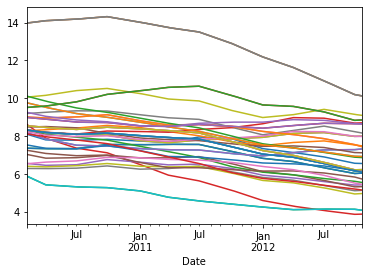

In [124]:
ax = data.pivot(columns='Store', index='Date', values='unemployment_interpolated').plot(legend=False)
#data.pivot(columns='Store', index='Date', values='Unemployment').plot(legend=False, ax=ax)